# SSIS - Spread Spectrum Image Steganography

In the 1990's and early 2000's, Lisa Marvel (my graduate student), Charles Retter, and I developed a fundamental steganography method we called SSIS (Spread Spectrum Image Steganography).  Lisa and Charles work for the US Army Research Laboratory.  Lisa has become one of the world's experts in steganography and steganalysis.  Charles is an expert in error correcting codes, especially for low signal to noise ratios.

Some quick definitions:

**cryptography**: system for translating a message into a language known only to sender and receiver, that language is determined by a cryptographic method, e.g., AES, and a secret key.
    
**cryptoanalysis**: attempt to break cryptosystems, can use any technique that works
    
**steganography**: system for hiding a message, typically by embedding the message inside a larger message, called the "envelope". Like cryptography, steganography also requires the  sender and receiver to agree on a method and to share a secret key.
    
**steganalysis**: attempt to detect steganography, usually by a third party.  
    
Cryptography and steganography are separate goals, but can be combined: anyone paranoid to hide the fact they are communicating is also likely to encrypt their messages.

## SSIS Basics

The basic idea is we encode the hidden message as Gaussian noise and add the message to the envelope (e.g., an image).  

Let me emphasize this: the encoded message is statistically indistinguishable from IID Gaussian noise (assuming the random number generator is strong). The best a steganalyst can say is the image has some Gaussian noise.  Many images naturally have Gaussian noise.  Our embedded noise looks no different from naturally occurring noise.

To explain the process, let's start with an old cryptographic idea: XOR'ing the data with a pseudo-random bit sequence.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand, randint
%matplotlib inline
%precision 3

#for my macbook, feel free to comment this line away
#%config InlineBackend.figure_format = 'retina'

'%.3f'

In actual practice, the `crypt` pseudo-random sequence below is chosen with a cryptographically secure pseudo-random number generator keyed by a secret key known only to sender and receiver.  For the purposes of this notebook, however, we use the standard pseudo-random number generator and ignore the secret key.

In [2]:
Message = randint(0,2,10)
Crypt = randint(0,2,10)
Encrypted = Message ^ Crypt #XOR
Message, Crypt, Encrypted

(array([0, 0, 0, 1, 1, 0, 1, 0, 1, 1]),
 array([1, 1, 0, 1, 1, 0, 1, 1, 1, 0]),
 array([1, 1, 0, 0, 0, 0, 0, 1, 0, 1]))

The `encrypted` sequence looks like a random sequence (looks like a duck, walks like a duck, quacks like a duck, so ...).  Even if we assume the `message` sequence is non-random, the `encrypted` sequence inherits the statistical properties of the `crypt` sequence.

Assuming each value of the `crypt` sequence is equally likely, each value of the `encrypted` sequence is equally likely regardless of the value of the `message` sequence.

Aside: This argument is surprisingly subtle.  It is considered improper to speak of the message as random.  It is what it is.  We have no control over that.  What we can control is the `crypt` sequence.  As long as the `crypt` sequence is random, the `encrypted` sequence is random.

## Part Way Home: Encoding Message as Uniforms

The core SSIS idea: For each bit in the message, generate a uniform random variable, U.  If the bit = 1, let $Y=U$; if the bit = 0, let $Y=g(U)$ where 

$$
g(U) = \begin{cases} U+0.5 & \text{for $0<U<0.5$}\\ U-0.5 & \text{for $0.5<U<1$} \end{cases}
$$

Note $\big|U-G(U)\big| = 0.5$ for all $0<U<1$. That this difference is bounded from below (i.e., greater than 0) allows us to decode the message.

The two functions are shown below.

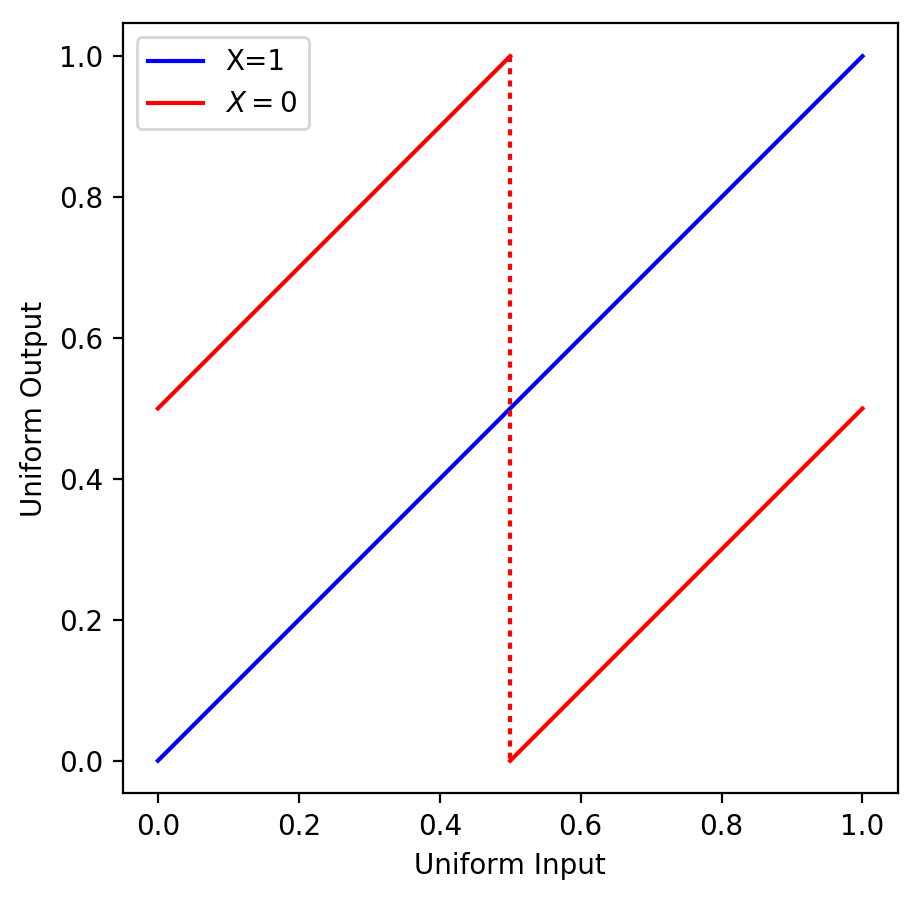

In [3]:
plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'b',label='X=1')
plt.plot([0.5,1],[0,0.5],'r')
plt.plot([0,0.5],[0.5,1],'r',label='$X=0$')
plt.plot([0.5,0.5],[1,0],':r')
plt.axis([-0.1,1.1,-0.1,1.1])
plt.axis('equal')
plt.xlabel('Uniform Input')
plt.ylabel('Uniform Output')
_ = plt.legend()

In [4]:
def g(u):
    """transformation of Uniforms"""
    return (u+0.5)*(u<0.5)+(u-0.5)*(u>=0.5)

#test it
u = np.linspace(0,1,10)
u, g(u), np.abs(u-g(u))

(array([ 0.   ,  0.111,  0.222,  0.333,  0.444,  0.556,  0.667,  0.778,
         0.889,  1.   ]),
 array([ 0.5  ,  0.611,  0.722,  0.833,  0.944,  0.056,  0.167,  0.278,
         0.389,  0.5  ]),
 array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5]))

## Modulate the pseudo-random uniform sequence by the data.

In [5]:
Message = randint(0,2,10)
Unifs = rand(10)
Encoded = Message*Unifs + (1-Message)*g(Unifs) 
Message, Unifs, Encoded

(array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1]),
 array([ 0.043,  0.129,  0.308,  0.141,  0.543,  0.87 ,  0.522,  0.543,
         0.033,  0.178]),
 array([ 0.543,  0.629,  0.308,  0.641,  0.043,  0.87 ,  0.522,  0.543,
         0.533,  0.178]))

Note when message = 1, the uniform is changed; when the message = 0, the uniform is unchanged. The resulting sequence is statistically indistinguishable from pseudo-random uniform noise.

## Generation of Pseudo-random Gaussian Noise

There are many techniques for generating pseudo-random Gaussian noise.  Here we focus on inverting the distribution function.  

Let $Z \sim N(0,1)$ and $U \sim U(0,1)$.  Let $F_Z(z) = Pr(Z\le z) = \Phi(z)$ and let $F_U(u) = Pr(U \le u) = u$ for $0<u<1$.  

We can generate Gaussians from uniforms by inverting the Gaussian distribution function.

$$ \begin{align}
Z &= \Phi^{-1}(U)\\
Pr(Z \le z) &= Pr(\Phi^{-1}(U) \le z) = Pr(U\le \Phi(z)) = \Phi(z)
\end{align}
$$

So we can generate Gaussians from Uniforms by applying the inverse distribution transformation.

Note, there are faster ways to generate Gaussian random variables than inverting the distribution function, but this is the simplest method to describe and it works well in SSIS.

In [6]:
from scipy.stats import norm
Phi_inv = norm.ppf
U = rand(10)
G = Phi_inv(U)
G

array([-1.132, -1.16 ,  0.405,  1.172, -0.265, -0.507,  0.684,  0.385,
        0.56 ,  2.439])

## Using the Message to Modulate a Gaussian noise sequence

Now that the encoded message is a modulated uniform sequence, we generate a modulated Gaussian sequence by applying the inverse of the distribution function.

In [7]:
Gaussians = Phi_inv(Encoded) #gaussian noise
Gaussians

array([ 0.109,  0.33 , -0.5  ,  0.361, -1.713,  1.129,  0.056,  0.108,
        0.084, -0.922])

## Some Properties of the Gaussian Embedding

First, look at the transformation for $X=0$ and $X=1$.

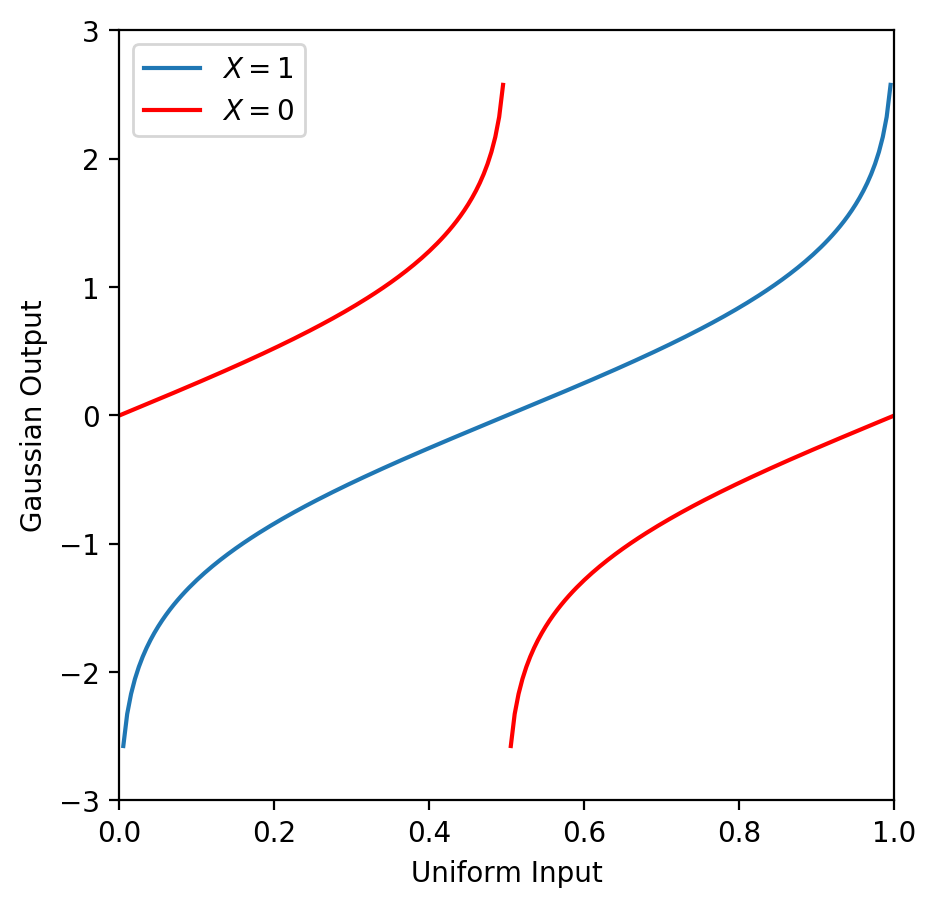

In [8]:
u = np.linspace(0,1,201)
plt.figure(figsize=(5,5))
plt.plot(u,Phi_inv(u),label='$X=1$')
plt.plot(u,Phi_inv(g(u)),'r', label='$X=0$')
plt.axis([0,1,-3,3])
plt.legend(loc=2)
plt.xlabel('Uniform Input')
plt.ylabel('Gaussian Output')

We are interested in the minimum vertical distance between the red and blue curves.  This occurs when $u=0.25$ and $u=0.75$ and has value 1.349.

Minimum vertical distance = 1.349


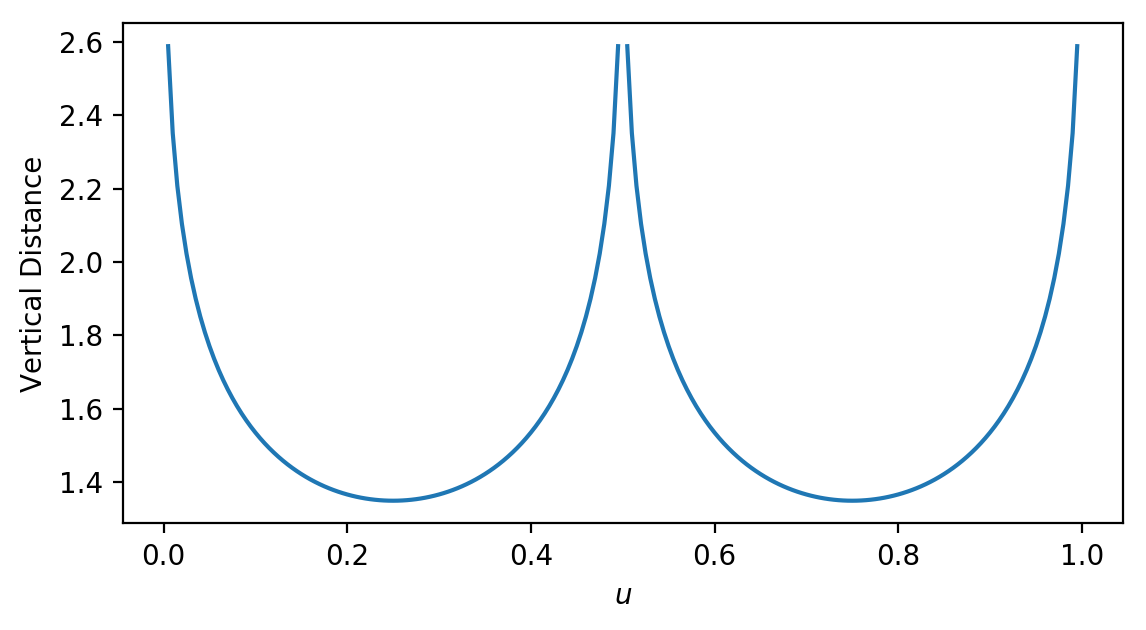

In [9]:
fig = plt.figure(figsize=(5,2.5))
ax = fig.add_axes([0,0,1,1])
plt.plot(u,np.abs(Phi_inv(u)-Phi_inv(g(u))))
plt.xlabel(r'$u$')
plt.ylabel(r'Vertical Distance')

#other ylabels I tried
#ax.text(-0.12,2.1,r'$\left|\Phi^{-1}(u)-\Phi^{-1}(g(u))\right|$',
#       horizontalalignment='right',
#       fontsize=12)
#plt.ylabel(r'$\left|\Phi^{-1}(u)-\Phi^{-1}(g(u))\right|$',
#           rotation='horizontal', horizontalalignment='right')

print('Minimum vertical distance = %.3f' % (Phi_inv(0.75)-Phi_inv(0.25)))

Let's test the process and verify the output sequence actually has a Gaussian distribution.

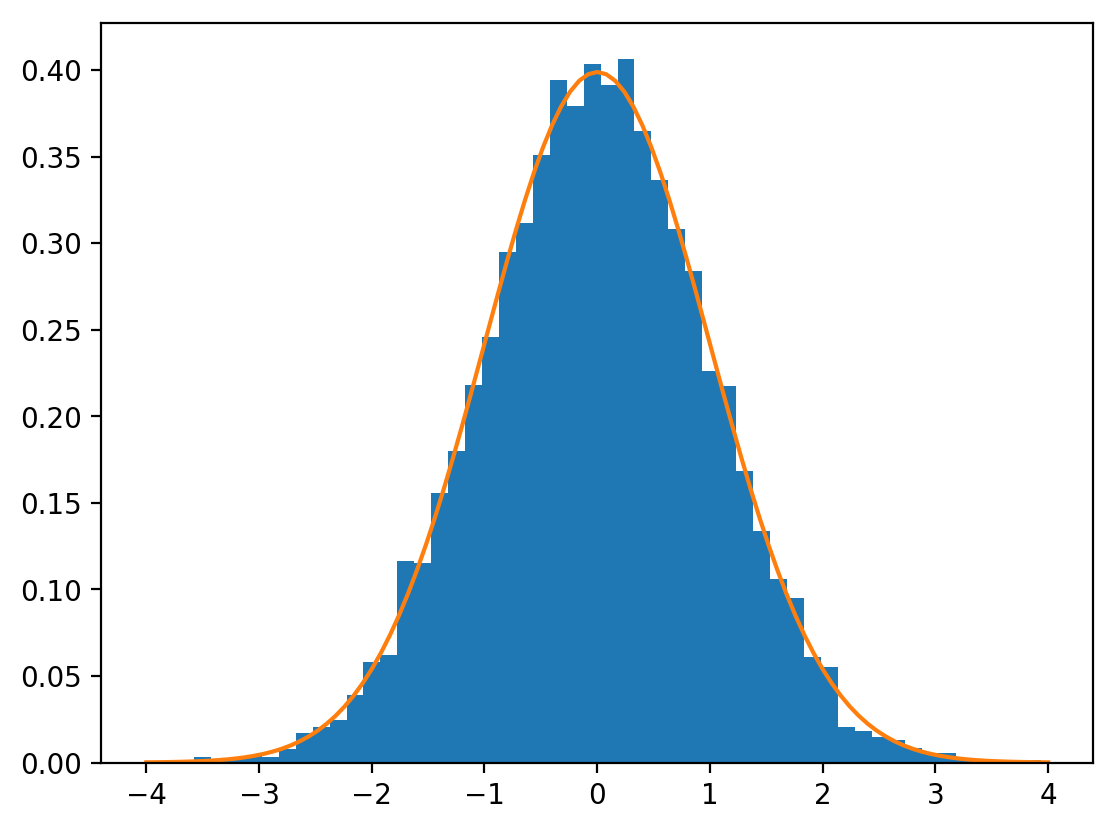

In [10]:
n = 10000
Mn = randint(0,2,n)
Un = rand(n)
En = Mn*Un + (1-Mn)*g(Un)
GNn = Phi_inv(En)

plt.hist(GNn,bins=51, normed=True)
x = np.linspace(-4,4,101)
_ = plt.plot(x, norm.pdf(x))

Look at the difference between $M=0$ and $M=1$.

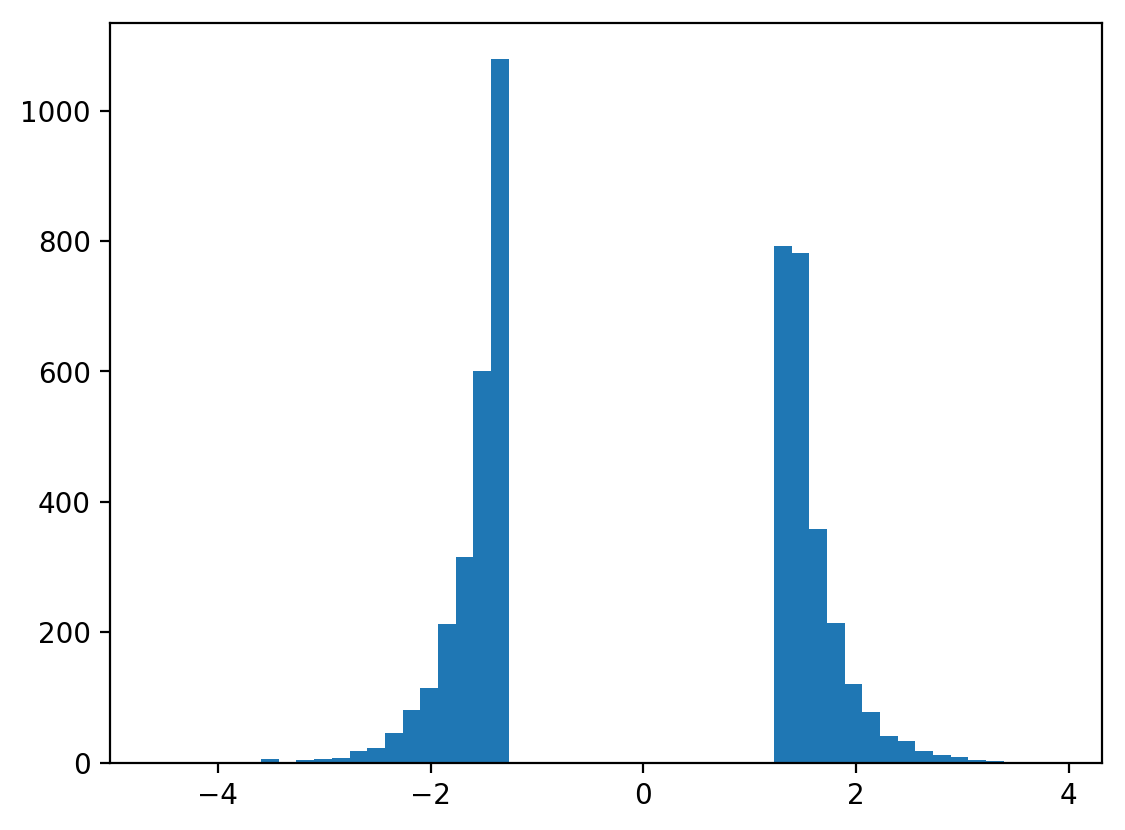

In [11]:
GN_diff = Phi_inv(g(Un[Mn==0])) - Phi_inv(Un[Mn==0])

_ = plt.hist(GN_diff,bins=51)

Notice the clear separation between the two groups.

## Embed the Message Into the Image

Image pixels are typically 8 bit integer values from 0 to 255 (per color).  Gaussian noise is continuous.  We need to assure the resulting image is quantized and clipped.

Create fake image data.

In [12]:
Image = randint(0,256,10)
Image

array([104, 234, 119, 175,  57, 140, 187,  33, 115, 113])

In [13]:
scale = 2.0
StegoImage_f = Image + scale*Gaussians
StegoImage = np.clip(np.round(StegoImage_f).astype('int'),0,255)
Gaussians, Image, StegoImage_f, StegoImage

(array([ 0.109,  0.33 , -0.5  ,  0.361, -1.713,  1.129,  0.056,  0.108,
         0.084, -0.922]),
 array([104, 234, 119, 175,  57, 140, 187,  33, 115, 113]),
 array([ 104.218,  234.66 ,  117.999,  175.722,   53.573,  142.257,
         187.112,   33.215,  115.168,  111.155]),
 array([104, 235, 118, 176,  54, 142, 187,  33, 115, 111]))

## Decode

We assume the Image data is known to both the sender and the receiver.  This is known as "non-blind" decoding.

In [14]:
Gaussians_hat = (StegoImage - Image)/scale
Gaussians_hat

array([ 0. ,  0.5, -0.5,  0.5, -1.5,  1. ,  0. ,  0. ,  0. , -1. ])

Generate Gaussians corresponding to $X=0$ and $X=1$.  Then see which is closer to `Gaussians_hat`.

In [15]:
G0 = Phi_inv(g(Unifs))
G1 = Phi_inv(Unifs)
G0, G1

(array([ 0.109,  0.33 ,  0.872,  0.361, -1.713, -0.331, -2.006, -1.719,
         0.084,  0.463]),
 array([-1.713, -1.13 , -0.5  , -1.076,  0.109,  1.129,  0.056,  0.108,
        -1.833, -0.922]))

In [16]:
X0 = np.abs(G0-Gaussians_hat)
X1 = np.abs(G1-Gaussians_hat)
Message_hat = np.where(X0<X1, 0, 1)
Message_hat, Message

(array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1]), array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1]))

In [17]:
errors = np.sum(np.abs(Message-Message_hat))
errors

0

## Summary

Here is a quick summary of the steps:

In [18]:
n = 100000
scale = 1.0 
Message = randint(0,2,n)
Image = randint(0,256,n)
Unifs = rand(n)
Encoded = Message*Unifs + (1-Message)*g(Unifs)
Gaussians = Phi_inv(Encoded)
StegoImage_f = Image + scale*Gaussians
StegoImage = np.clip(np.round(StegoImage_f).astype('int'),0,255)
Gaussians_hat = (StegoImage - Image)/scale
G0 = Phi_inv(g(Unifs))
G1 = Phi_inv(Unifs)
X0 = np.abs(G0-Gaussians_hat)
X1 = np.abs(G1-Gaussians_hat)
Message_hat = np.where(X0<X1, 0, 1)
errors = np.sum(np.abs(Message-Message_hat))
errors

221

Rounding (especially when `scale` is small) and clipping to 0 and 255 causes the errors. 

## The Rest of the Story

We have explained how the message we intend to hide is modulated as Gaussian noise and embedded into the image.  There are a few other considerations:

1. The sender usually adds error correction bits and may interleave the bits, so adjacent bits are far apart.
2. The `scale` parameter is important.  Making it too small results in many errors; too large and the embedded noise significantly reduces image quality.
3. Above we assumed the receiver knows the original image.  If this is not the case ("blind" detection), the receiver needs to estimate the image.  One recommended way is to apply a good noise reduction algorithm to the received image and subtract the resulting *smoothed* image from the received image to obtain an estimate of the embedded Gaussian noise.
4. Typically when doing blind detection, the estimate of the embedded Gaussian noise is "noisy".  The raw decoded error rate may be high.  It is important to use ECC to lower the error rate to an acceptable level.  E.g., using low rate codes and soft decision decoding.

## References

1. Marvel, Lisa M., Charles G. Boncelet, and Charles T. Retter. "Spread spectrum image steganography." IEEE Transactions on image processing 8.8 (1999): 1075-1083.

2. Boncelet Jr, Charles G., Lisa M. Marvel, and Charles T. Retter. "Spread spectrum image steganography." U.S. Patent No. 6,557,103. 29 Apr. 2003.

3. Marvel, Lisa M., Charles G. Boncelet Jr, and Charles T. Retter. "Reliable blind information hiding for images." International Workshop on Information Hiding. Springer Berlin Heidelberg, 1998.

4. Marvel, Lisa M., Charles T. Retter, and Charles G. Boncelet. "A methodology for data hiding using images." Military Communications Conference, 1998. MILCOM 98. Proceedings., IEEE. Vol. 3. IEEE, 1998.

5. Marvel, Lisa M., Charles T. Retter, and Charles G. Boncelet. "Hiding information in images." Image Processing, 1998. ICIP 98. Proceedings. 1998 International Conference on. Vol. 2. IEEE, 1998.

----
Charles Boncelet, <boncelet@udel.edu>, 4/13/17